In [1]:
# Import libraries for workflow
import warnings
import os
from glob import glob
import h5py
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.stats.stats import pearsonr
import pysptools.eea as eea  
import pysptools.abundance_maps as amap
import pandas as pd
import earthpy as et
from earthpy.spatial import bytescale

# Helper functions from NEON's Hyperspectral Tutorial
from blog_helper_functions import *

%matplotlib inline

# Turn off warnings
warnings.filterwarnings('ignore')

# Check directory exists and set working directory
working_dir = os.path.join(et.io.HOME, 'earth-analytics')
if os.path.exists(working_dir) == False:
    os.mkdir(working_dir)
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

<a data-flickr-embed="true" href="https://www.flickr.com/photos/usfwsmtnprairie/30026674155/" title="Sunset on Seedskadee National Wildlife Refuge"><img src="https://live.staticflickr.com/5315/30026674155_d4d890b0ad_6k.jpg" width="6144" height="1913" alt="Sunset on Seedskadee National Wildlife Refuge"></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>
<center>Figure: Sunset on Seedskadee National Wildlife Refuge, WY</center>
<center>Image Source: <a href="https://www.flickr.com/photos/usfwsmtnprairie/30026674155/" target="_blank">USFWS Mountain-Prairie, Tom Koerner</a> </center>

# Sage Advice: *Can Remote Sensing Data Inform Sagebrush Conservation?*
Author:
<div>Kelsey Beckrich, CU Boulder Earth Data Analytics</div>
Collaborators: 
<div>Sarah Jaffe, CU Boulder Environmental Studies<br>
NatureServe </div>

This project attempted to use a combination of LIDAR-derived canopy height models (CHM) and spectrometer-derived abundance maps to determine the vegetation structure/composition in sagebrush ecosystems. We found a variety of relevant open source data, but the low-growing vegetation characteristic of sagebrush ecosystems makes it difficult to validate remote-sensing models. In fact, the short stature of sagebrush rendered our CHMs obsolete and meant that the coordinates for the sagebrush observed in the *insitu* data were not recorded because the small shrubs were invisible to remote sensing instruments (Ben-Arie et al., 2009; Goulden & Scholl, 2019; NEON, 2020).

Despite these challenges, we found a workaround to validate our results which suggest that at least hyperspectral imagery has potential to detect sagebrush and cheatgrass. Unfortunately, this potential is unmet until on-the-ground data considers more inclusive approaches to validate remote sensing instruments in arid/semi-arid environments.


##  Why are we looking for sagebrush?

Sagebrush habitats support hundreds of species of plants and animals across Western United States (Knick et al., 2003). It is estimated that the 150 million acre range of sagebrush has declined by 56% in the last 100 years, and the remaining sagebrush habitats are heavily fragmented from commercial landuse and invasive species (Davies et al., 2011; Knick et al., 2003; MacArthur & Plummer, 1978). Fragmented and reduced sagebrush habitat has very real impacts - see below for the change in greater sage grouse range, one of several bird species that live only in sagebrush (Knick et al., 2003; Aldrigdge et al., 2008). This sage grouse map also illustrates the challenges of sagebrush conservation. Clearly, using remote sensing data to take the strain off traditional field surveys would benefit conservation efforts over such a dispersed ecosystem.
<img src="https://nca2014.globalchange.gov/sites/report/files/images/web-large/Figure-19.7-hi.jpg" alt="Current and Historical Sage Grouse Habitat Distribution" width="400"/>

<center>Figure: The current and historical habitat distributions of the Greater Sage Grouse</center>
<center>Image Source: <a href="https://nca2014.globalchange.gov/sites/report/files/images/web-large/Figure-19.7-hi.jpg" target="_blank">Aldridge et al. 2008</a> </center>


# How can we see sage remotely?

<img src="https://live.staticflickr.com/4420/36940014932_684e400a70_b.jpg"  width="600" height="500" alt="Sagebrush surrounded by cheatgrass"><center>Image Source:<a href="https://flic.kr/p/Yhgetb" target="_blank" > USFWS </a><br> Sagebrush surrounded by cheatgrass</center>

<p>As pictured here in June, sagebrush shrubs stand out against invasive cheatgrass. Cheatgrass runs through its lifecycle before native plants green up, creating stark visual contrast for us. We had already determined that the height difference between grasses and shrubs couldn't be captured with standard LIDAR CHM from our previous work, but we wanted to see if spectral data could capture these distinctive colors. The next question was how would these colors looks to a spectrometer?

## Sagebrush and Spectral Data 

Spectrometers record the actual wavelengths of light reflected from the ground and groups these wavelengths into sections called bands. Looking at the amount of light reflected in each band allows us to detect objects on the ground through their 'spectral signature', a unique curve generated by plotting the reflected light at each wavelength from an object. By analyzing these spectral signatures, we can understand how spectrometers 'see' and record different objects.

Spectral data comes in a variety of resolutions, and it is unclear how fine resolution is needed to identify something as specific as a single plant species, like sagebrush. Consequently, Sarah Jaffe and I developed the same workflow for two different data products: LANDSAT8's multispectral images captured via satellite (per pixel resolution: 30 meters squared, 7 spectral bands) and NEON's hyperspectral images captured via aircraft (resolution: 1 meter squared, 426 spectral bands). The following post focuses on the results from my hyperspectral workflow. Results from Sarah Jaffe's multispectral analysis can be viewed by clicking on her link under Resources.

In [2]:
# Imports tile 378000_4452000
et.data.get_data(url='https://ndownloader.figshare.com/files/23535953')

# Import hyp data into dict with tile number as key
ONAQ_hyp_refl = glob(os.path.join('data', 'earthpy-downloads', '*DP3*'))

# File import is scalable if multiple tiles are available
ONAQ_data = {}
for file in ONAQ_hyp_refl:
    data, metadata = read_neon_reflh5(file)
    data_clean, metadata_clean = clean_neon_refl_data(
        data, metadata)
    ONAQ_data[os.path.basename(file)[18:32]] = {
        'reflectance': data_clean,
        'metadata': metadata_clean}

In [3]:
# Download data hosted on figshare
et.data.get_data(
    url='https://ndownloader.figshare.com/files/23262782')
et.data.get_data(
    url='https://ndownloader.figshare.com/files/23262785')

# Create list of directories to spectral signatures
AV_spect_lib_dir = glob(os.path.join('data', 'earthpy-downloads', '*AV14*'))
AV_spect_sig = {}

# Remove unnecessary files, import reflectance and wavelength as arrays
for dirs in AV_spect_lib_dir:
    error_bar = sorted(glob(os.path.join(dirs, '*errorbar*')))
    resolution_file = sorted(glob(os.path.join(dirs, '*Resolution*')))
    if not len(error_bar) == 0:
        os.remove(error_bar[0])
    if not len(resolution_file) == 0:
        os.remove(resolution_file[0])
    txt_files = sorted(glob(os.path.join(dirs, '*txt*')))

    # Use vegetation type name from file path as dict key
    object_name = os.path.basename(txt_files[0]).split('_')[2]
    AV_spect_sig[object_name] = {
        'Resolution': np.loadtxt(txt_files[0], skiprows=1),
        'Wavelength': np.loadtxt(txt_files[1], skiprows=1)}

# Clean spectral library bad reflectance values
cheatgrass_res, cheatgrass_wave = clean_spectral_array(
    object_spect_dict=AV_spect_sig['Cheatgrass'])
sagebrush_res, sagebrush_wave = clean_spectral_array(
    object_spect_dict=AV_spect_sig['Sagebrush'])

# Interpolate spectral library data to match hyperspectral dimension
interp_res_sagebrush = np.interp(np.array(
    ONAQ_data['378000_4452000']['metadata']['wavelength']),
    sagebrush_wave,
    sagebrush_res)
interp_res_cheatgrass = np.interp(
    np.array(ONAQ_data['378000_4452000']['metadata']['wavelength']),
    cheatgrass_wave,
    cheatgrass_res)

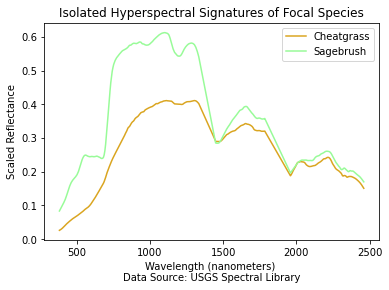

**************************************************
These spectral signatures are 86 percent similar.


In [4]:
# Plot spectral signatures from library
plot_path = os.path.join(
    'data', 'outputs', 'sagebrush_cheatgrass_sl_signatures.png')
fig, (ax) = plt.subplots()
ax.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
        interp_res_cheatgrass, label='Cheatgrass',
        color='goldenrod')
ax.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
        interp_res_sagebrush, label='Sagebrush',
        color='palegreen')
ax.set_xlabel('Wavelength (nanometers) \n'
              'Data Source: USGS Spectral Library',
              fontsize=10)
ax.set_title('Isolated Hyperspectral Signatures of Focal Species')

ax.set_ylabel('Scaled Reflectance')
plt.legend()
plt.savefig(plot_path,
            transparent=True)
plt.show()
print('**************************************************')
print('These spectral signatures are',
      int(pearsonr(interp_res_cheatgrass, interp_res_sagebrush)[0]*100),
      'percent similar.')

This plot shows the pure spectral signatures for sagebrush and cheatgrass. It confirms that their signatures are similar, which is expected for vegetation, but they are distinct. Once I had the pure signatures from the two species we wanted to identify remotely, I utilized an algorithm to 'search' through an image to find one or both of our target species.

## Searching for Sagebrush with an Endmember Extraction Algorithm

Every pixel in these images includes some combination of land cover types (soil, water, vegetation, etc.) with their own spectral signatures. While the variation in land cover captured in each pixel will vary depending on the image resolution and landscape, we need to tease apart the spectral signatures of these component land covers within each pixel - a process known as endmember extraction. If we can accurately match these endmembers to the known signatures of cheatgrass and sagebrush, we can then plot the proportion of sage or cheatgrass in each pixel of the image - a process known as abundance mapping. 


In [ ]:
# Defines endmember extraction object and extracts 7 endmembers
ee = eea.NFINDR()
U = ee.extract(ONAQ_data['378000_4452000']['reflectance'], 7, maxit=10,
               normalize=False, ATGP_init=True)
# Defines abundance map object and creates abundance maps
am = amap.FCLS()
amaps = am.map(ONAQ_data['378000_4452000']['reflectance'],
               U, normalize=False)  # create abundance maps for the HSI cubems
# Calculate PCC for all endmembers and store in a list
coefficient_sagebrush = []
coefficient_cheatgrass = []
for i in range(0, U.shape[0]):
    coefficient_sagebrush.append(pearsonr(
        interp_res_sagebrush, U[i])[0])
    coefficient_cheatgrass.append(pearsonr(
        interp_res_cheatgrass, U[i])[0])

# Find the highest PCC for each species
closest_correl_sage = np.array(coefficient_sagebrush).max()
closest_correl_cheat = np.array(coefficient_cheatgrass).max()

# Create plot of all endmembers
plt.figure(figsize=(16, 8))
plt.xlabel('Wavelengths - nanometers \n Data Source: NEON (May 2019)',
           fontsize=14)
plt.ylabel('Scaled Reflectance',
           fontsize=14)
n_em = 0
for endmember in U:
    n_em += 1
    plt.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
             endmember,
             label=f'EM{n_em}')
plt.legend()
plt.title(f'Extracted {n_em} Endmembers from NEON Hyperspectral Tile \nOnaqui, Utah',
          fontsize=16)

plt.show()

# Plot triptych of endmember, rgb tile, and endmember abundance
n_em = 0
for i, em in enumerate(U):
    n_em += 1
    fig = plt.figure(figsize=(16, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    # ax0 is endmember line plot
    ax0 = plt.subplot(gs[0])
    p0 = ax0.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'], em)
    ax0.grid(True)
    ax0.set_ylim(0, 0.6)
    ax0.set_xlabel('Wavelength (nanometers) \n'
                   'Data Source: NEON (May 2019)',
                   fontsize=10)
    ax0.set_ylabel('Scaled Reflectance',
                   fontsize=10)

    # Label closest match to sage/cheatgrass and print percent correlation
    if (pearsonr(interp_res_sagebrush, em)[0]) == closest_correl_sage:
        plt.title(
            f'Endmember {n_em} {int(closest_correl_sage*100)}% Correlation to Sagebrush')
    elif (pearsonr(interp_res_cheatgrass, em)[0]) == closest_correl_cheat:
        plt.title(
            f'Endmember {n_em} {int(closest_correl_cheat*100)}% Correlation to Cheatgrass')
    else:
        plt.title(f'Endmember {n_em}')

    # ax1 is RGB tile
    ax1 = plt.subplot(gs[1])
    ax1.set_axis_off()
    im1 = ax1.imshow(
        bytescale(ONAQ_data['378000_4452000']['reflectance'][:, :, [54, 34, 22]]))
    plt.title('True Color Image NEON Tile')

    # ax2 is abundance map
    ax2 = plt.subplot(gs[2])
    im2 = ax2.imshow(amaps[:, :, i], cmap='jet')
    ax2.set_axis_off()
    plt.title(f'Endmember {n_em} Abundance Map')

    # Configure cmap scale bar
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="10%", pad=0.001)

    plt.colorbar(im2, cax=cax)
    plt.show()

## Extracted Endmembers and Abundance Maps
The first plot shows the 7 most prominent landcover types. We can't confirm what these are, but, generally, spectral curves that sit high on graphs (reflect a lot of light) are soil, see endmembers 7. Curves that sit low on graphs (absorb a lot of light) are usually water, endmembers 1. Spectral curves reflecting a lot of light in the near infrared spectrum (wavelengths 850 - 880) are generally vegetation.

The next plots show each isolated endmember with a color image of the site and an abundance map of that endmember (landcover). Notably, endmembers 3 and 5 correlate with the spectral signatures of sagebrush and cheatgrass from the spectral library. Looking at their abundance maps, we can start to get a sense of their abundance and distribution on site. We can also make some educated guesses about the identity of endmembers 6, which is showing a high proportion along some stream or dry streambed areas, suggesting that it may be a type of tree thriving in higher moisture area, and endmember 7, which is lighting up the abundance map on top of the dirt road.

In [ ]:
# Creat plots of the spectral signatures from the isolated libraries and suspected endmembers
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle('Comparison of Pure Spectral Signatures with Extracted Endmembers',
             fontsize=16)

# Plot for cheatgrass spectra comparison
ax0.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
         interp_res_cheatgrass, label='Interpolated Cheatgrass',
         color='darkgoldenrod')
ax0.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
         U[2], color='palegoldenrod',
         label='Endmember 3')
ax0.set_xlabel('Wavelength (nm) \n'
               'Data Source: USGS Spectral Library \n NEON',
               fontsize=10)
ax0.set_ylabel('Reflectance')
ax0.set_title('Cheatgrass Spectral Signatures (90% Correlation)')
ax0.legend()

# Plot for sagebrush comparison
ax1.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
         interp_res_sagebrush, label='Interpolated Sagebrush',
         color='darkseagreen')
ax1.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
         U[4],
         label='Endmember 5',
         color='palegreen')
ax1.set_xlabel('Wavelength (nm) \n'
               'Data Source: USGS Spectral Library \n NEON',
               fontsize=10)

ax1.set_ylabel('Reflectance')
ax1.set_title('Sagebrush Spectral Signatures (99% Correlation)')
ax1.legend()
plt.show()

## Comparison of Pure Spectral Signatures and Extracted Endmembers
The last step is comparing the known spectral signatures of sagebrush and cheatgrass with the endmembers they statistically resemble. We can see from the above plots that the reflectance values differ, the reflectance values could vary by instrument or location, so what we really want to focus on is the curves. Focusing on just the curves, we do see some similarities between cheatgrass and endmember 3 and some significant similarities between sagebrush and endmember 5.

# What We've Learned about Remote Sensing and Sagebrush

The hyperspectral findings show that we can identify several landcover types onsite, and some of these look a bit like cheatgrass and some a lot like sagebrush. Manually collected data tells us there is sagebrush and cheatgrass in this general area, but confirming that the sage-like spectra we see remotely is the actual sage recorded on the ground is not possible without the exact coordinates of the plants recorded, measured, and identified manually (NEON, 2019). So we can hazard some educated guesses for conservationists at where sagebrush and cheatgrass might be, but we would be much more confident in those guesses if we could validate what we see against documented plants in the area.

While I don't have the resources to collect necessary data, I recognize that there are additional data not published for open use. I also hope that these findings will prompt some discussion on how we validate data in arid/semi-arid environments with dwarfed vegetation. It seems like either 1) cataloging the spectral signatures of representative vegetation or 2) considering population size over individual size may be more useful for validating remotely detected vegetation types in these ecosystems. For these reasons, I'm working on a script to extract spectral signatures from spatially high resolution data which would be applicable for either mapped *insitu* data or cataloged spectral signatures. 



# Resources
## Check out our code on github!<br>
Kelsey Beckrich's endmember extraction and abundance mapping for <a href= "https://github.com/kessb/sagebrush-ecosystem-modeling" target = "_blank" >  hyperspectral</a> (NEON) data<br>
Sarah Jaffe's endmember extraction and abundance mapping for <a href="https://github.com/sarahmjaffe/sagebrush-ecosystem-modeling-with-landsat8" target = "_blank" >  multispectral</a> (LANDSAT8) data   
Kelsey and Sarah's validation workflow for NEON's <a href= "https://github.com/kessb/sagebrush-ecosystem-modeling/tree/master/scripts" target="blank" >LIDAR</a> CHM data
## References
<a href="https://onlinelibrary.wiley.com/doi/full/10.1111/j.1472-4642.2008.00502.x" target= "blank" >Aldridge, C. L., S. E. Nielsen, H. L. Beyer, M. S. Boyce, J. W. Connelly, S. T. Knick, and M. A. Schroeder. 2008. Range‐wide patterns of greater sage‐grouse persistence. Diversity and Distributions 14: 983– 994. </a><br>
<a href = "https://www-sciencedirect-com.colorado.idm.oclc.org/science/article/pii/S0098300409000624" target = "_blank" > Ben-Arie, J. R., Hay, G. J., Powers, R. P., Castilla, G., & St-Onge, B. (2009). Development of a pit ﬁlling algorithm for lidar canopy height models. Computers & Geosciences, 35(9), 1940–1949. </a><br>
<a href= "https://www.sciencedirect.com/science/article/pii/S0006320711002692" target ="blank" >  Davies, K.W.; Boyd, C.S.; Beck, J.L.; Bates, J.D.; Svejcar, T.J.; Gregg, M.A. 
Saving the sagebrush sea: An ecosystem conservation plan for big sagebrush plant communities
Biol. Conserv., 144 (11) (2011), pp. 2573-2584</a><br>
Goulden, T. & Scholl, V., NEON Algorithm Theoretical Basis Document (ATBD): Ecosystem structure. (2019) Provisional data downloaded from http://data.neonscience.org on July, 3 2020. Battelle, Boulder, CO, USA NEON. 2020.</a><br>
<a href = "https://www-jstor-org.colorado.idm.oclc.org/stable/1370568?pq-origsite=summon&seq=3#metadata_info_tab_contents" target = "blank" > Knick, S.T.; Dobkin, D.S.; Rotenberry, J.T.; Schroeder, M.A,; Vander Haegen, W.M; Riper, C.V.
Teetering on the edge or too late? Conservation and research issues for avifauna of sagebrush habitats
The Condor, 105 (2003), pp. 611-634 </a><br>
<a href= "https://data.neonscience.org/data-products/DP1.10098.001" target = "blank" > National Ecological Observatory Network. 2020. Data Product DP1.10098.001, Woody plant vegetation structure. Provisional data downloaded from http://data.neonscience.org on April 23, 2020. Battelle, Boulder, CO, USA NEON. 2019.</a><br>
McArthur, E.D.; Plummer, A.P. Biogeography and management of western native shrubs: a case study, section Tridentatae of Artemisia., Great Basin Nat. Mem., 2 (1978), pp. 229-243
## Acknowledgements
This work couldn't have been done without support from Earth Labbers Jenny Palomino and Joe McGlinchy.